# UCL Online Retail Dataset

This is a transnational data set which contains all the transactions occurring from December 1st 2010 until December 9th 2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. Each row represents the transaction that occurs. It includes the product name, quantity, price, and other columns that represents ID.

Source: http://archive.ics.uci.edu/ml/datasets/Online+Retail (Dr Daqing Chen, Director: Public Analytics group. chend '@' lsbu.ac.uk, School of Engineering, London South Bank University, London SE1 0AA, UK.)

#### Column Descriptions

<br> 

| Column Name | Description | Data Type |
|:--|:--|:--|
| InvoiceNo | Invoice number.If this code starts with letter 'c', it indicates a cancellation. | Nominal, a 6-digit integral number uniquely assigned to each transaction |
| StockCode | Product (item) code | Nominal, a 5-digit integral number uniquely assigned to each distinct product |
| Description | Product (item) name. | Nominal |
| Quantity | The quantities of each product (item) per transaction. | Numeric |
| InvoiceDate | Invice Date and time | Numeric, the day and time when each transaction was generated |
| UnitPrice | Unit price | Numeric, Product price per unit in sterling  |
| CustomerID | Customer number | Nominal, a 5-digit integral number uniquely assigned to each customer |
| Country | Country name | Nominal, the name of the country where each customer reside |



<br>

### Plan

Before we get into the process, I will give you a brief on what kind of steps we will get.

1. Reading data and preprocessing
2. Create Recency Frequency Monetary (RFM) table	
3. Model - Clustering with K-means algorithm
4. Interpret the result


In [71]:
import sys
import pandas as pd
import numpy as np
import plotly.express as px
import plotly as py
import matplotlib.pyplot as plt 
import seaborn as sns 

from collections import Counter
from PIL import Image

import pandas as pd
from pathlib import Path

import calendar
!pip install termcolor
from termcolor import colored
from IPython.display import HTML

import warnings
warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

## Step 1 Reading data and preprocessing
In this step, we will gather the data first. For this case, we will take the data from UCI Machine Learning called Online Retail dataset.

In [72]:
df= pd.read_excel("online_retail_II.xlsx")
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [74]:
print("Number of rows in dataset is: ", df.shape[0])
print("Number of columns in dataset is: ", df.shape[1])

Number of rows in dataset is:  525461
Number of columns in dataset is:  8


### Wrangle, prepare, cleanse the data
#### ---- Start the data cleaning----

We need to make sure the data is clean before starting your analysis. As a reminder, we should check for:

- Duplicate records
- Consistent formatting
- Missing values (Remove the canceled order)
- Obviously wrong values (Remove the transaction with negative quantity)

#### Duplicate Records
- How many duplicate transaction records are there?

In [75]:
print('Duplicate entries: {}'.format(df.duplicated().sum()))
print('{}% rows are duplicate.'.format(round((df.duplicated().sum()/df.shape[0])*100),2))
#Remove duplicate data
df.drop_duplicates(inplace = True)

Duplicate entries: 6865
1% rows are duplicate.


#### Consistent formatting

In [76]:
df['Customer ID'] = df['Customer ID'].astype(str)

In [77]:
df.describe()

,Quantity,Price
count,518596.000000,518596.000000
mean,10.438152,4.716176
std,108.126593,147.090460
min,-9600.000000,-53594.360000
25%,1.000000,1.250000
50%,3.000000,2.100000
75%,10.000000,4.210000
max,19152.000000,25111.090000


Checking the total number of products, transactions and customers.

In [78]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['Invoice'].value_counts()),
               'customers': len(df['Customer ID'].unique().tolist()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,4632,28816,4384


#### Missing values
Removing cancelled orders from the data. Filtering transaction with invoice number started with letter 'C' and missing Customer ID.

#### Removing cancelled orders

In [79]:
cancelled = df['Invoice'].astype(str).str.contains('C')
cancelled.fillna(0, inplace=True)
cancelled = cancelled.astype(int)
cancelled.value_counts()

0    508414
1     10182
Name: Invoice, dtype: int64

In [80]:
df['order_canceled'] = cancelled
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,order_canceled
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,0


In [81]:
n1 = df['order_canceled'].value_counts()[1]
n2 = df.shape[0]
print("Number of cancelled transactions:", n1)
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))
df = df[df['order_canceled'] == 0]

Number of cancelled transactions: 10182
Number of orders canceled: 10182/518596 (1.96%) 


In [82]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,order_canceled
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,0


#### Removing transaction with missing Customer ID
We find out that CustomerID values are missing for those customers which have negative quantity values. Therefore, we will remove them too.

In [83]:
df = df[df['Customer ID'].notna()]

#### Obviously wrong values
Remove transaction with negative values for price and quantity

In [84]:
print("Total number of transaction with negative quantity:", df[df['Quantity'] <= 0 ]['Quantity'].count())
print("Precentage of transactions with zero or negative quantity" ,round(len(df[df['Quantity']<=0])/len(df)*100, 2),"%")
print("Total number of transaction with negative Price:", df[df['Price'] <= 0 ]['Price'].count())
print("Precentage of transactions with zero or negative price" ,round(len(df[df['Price']<=0])/len(df)*100, 2),"%")

Total number of transaction with negative quantity: 2121
Precentage of transactions with zero or negative quantity 0.42 %
Total number of transaction with negative Price: 3684
Precentage of transactions with zero or negative price 0.72 %


In [85]:
df = df[(df['Price'] > 0) & (df['Quantity'] > 0)]

In [86]:
print("Number of rows in dataset is: ", df.shape[0])
print("Number of columns in dataset is: ", df.shape[1])

Number of rows in dataset is:  504730
Number of columns in dataset is:  9


#### ---- End the data cleaning----

## Step 2 Create Recency Frequency Monetary (RFM) table

RFM is abasic customer segmentation algorithm based on their purchasing behaviour. The behaviour is identified by using only three customer data points: 

1. Recency: the recency of purchase/ How many days ago was their last purchase?
2. Frequency: the frequency of purchases/ total number of purchases/How many times has the customer purchased from our store?
3. Monetary: the mean monetary value of each purchase/the amount they have spent/How much has this customer spent? Again limit to last two years – or take all time

The RFM Analysis will help the businesses to segment their customer base into different homogenous groups so that they can engage with each group with different targeted marketing strategies. Sometime RMF is also used to identify the High-Value Customers (HVCs). 

In [87]:
print('Start date:' , df['InvoiceDate'].min())
print('End date:' , df['InvoiceDate'].max())

Start date: 2009-12-01 07:45:00
End date: 2010-12-09 20:01:00


In [88]:
# Create revenue colummn
df['Revenue'] = df['Price'] * df['Quantity']
# Convert to show date only
from datetime import datetime
df["InvoiceDate"] = df["InvoiceDate"].dt.date

In [89]:
import datetime as dt
snapshot_date = max(df.InvoiceDate) + dt.timedelta(days=1)

In [90]:
# RFM table
# Aggregate data by each customer
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days, 'Invoice': lambda x: len(x), 'Revenue': lambda x: x.sum()}).reset_index()
rfm['InvoiceDate'] = rfm['InvoiceDate'].astype(int)

# Rename columns
rfm.rename(columns={'InvoiceDate': 'Recency', 
                         'Invoice': 'Frequency', 
                         'Revenue': 'MonetaryValue'}, inplace=True)

In [91]:
rfm.head()

,Customer ID,Recency,Frequency,MonetaryValue
0,12346.0,165,33,372.86
1,12347.0,3,71,1323.32
2,12348.0,74,20,222.16
3,12349.0,43,102,2671.14
4,12351.0,11,21,300.93


Right now, the dataset consists of recency, frequency, and monetary value column. But we cannot use the dataset yet because we have to preprocess the data more.

### Manage Skewness and Scaling
We have to make sure that the data meet these assumptions:

#### The data should meet assumptions where the variables are not skewed and have the same mean and variance.

Because of that, we have to manage the skewness of the variables. Here are the visualizations of each variable.

### Explore the data
#### Recency, Frequency,MonetaryValue distributions

In [92]:
# fig, ax = plt.subplots(1, 3, figsize=(15,3))
# sns.distplot(rfm['Recency'], ax=ax[0])
# sns.distplot(rfm['Frequency'], ax=ax[1])
# sns.distplot(rfm['MonetaryValue'], ax=ax[2])
# plt.tight_layout()
# plt.show()

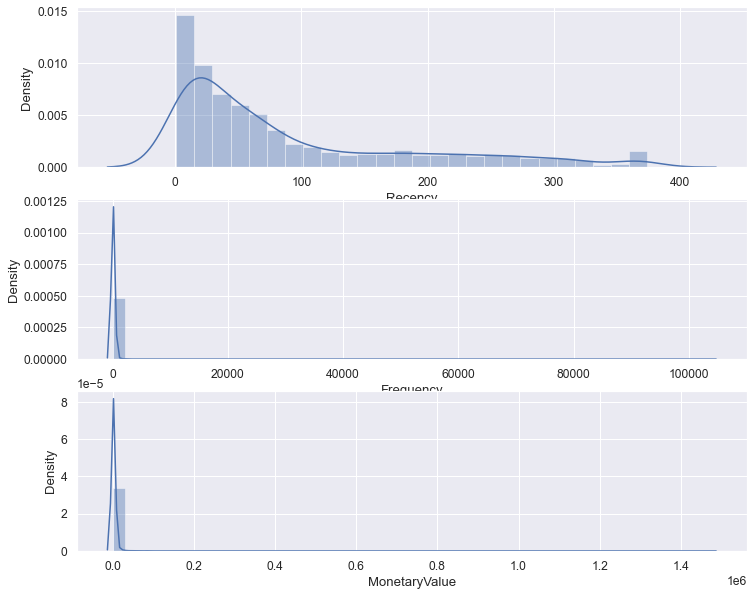

In [93]:
plt.figure(figsize=(12,10))

# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(rfm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(rfm['MonetaryValue'])

# Show the plot
plt.show()

As we can see from above, we have to transform the data, so it has a more symmetrical form.
There are some methods that we can use to manage the skewness:
- log transformation
- square root transformation
- box-cox transformation
Note: We can use the transformation if and only if the variable only has positive values.

In [94]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(rfm[x], ax=ax[0,0])
    sns.distplot(np.log(rfm[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(rfm[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(rfm[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
#     print(rfm[x].skew().round(2))
#     print(np.log(rfm[x]).skew().round(2))
#     print(np.sqrt(rfm[x]).skew().round(2))
#     print(pd.Series(stats.boxcox(rfm[x])[0]).skew().round(2))
    
    print('Log Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', np.log(rfm[x]).skew().round(2))
    print('Square Root Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', np.sqrt(rfm[x]).skew().round(2))
    print('Box-Cox Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', pd.Series(stats.boxcox(rfm[x])[0]).skew().round(2))

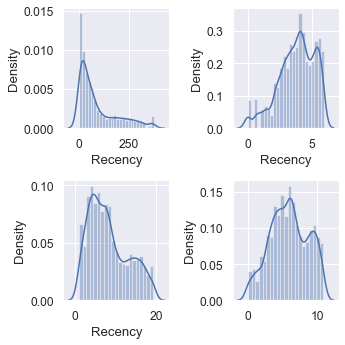

Log Transform : The skew coefficient of 1.28 to -0.62
Square Root Transform : The skew coefficient of 1.28 to 0.59
Box-Cox Transform : The skew coefficient of 1.28 to -0.07


In [95]:
analyze_skewness('Recency')

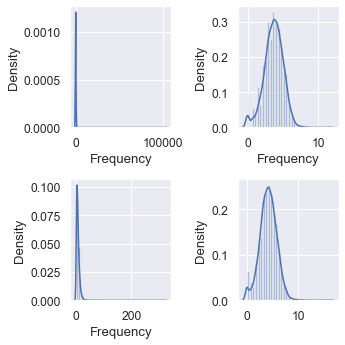

Log Transform : The skew coefficient of 64.17 to -0.27
Square Root Transform : The skew coefficient of 64.17 to 19.51
Box-Cox Transform : The skew coefficient of 64.17 to 0.02


In [96]:
analyze_skewness('Frequency')

Based on that visualization, it shows that the variables with box-cox transformation shows a more symmetrical form rather than the other transformations. To make sure, we calculate each variable using the skew function. The result:

Recency
- Log Transform : The skew coefficient of 1.28 to -0.62
- Square Root Transform : The skew coefficient of 1.28 to 0.59
- Box-Cox Transform : The skew coefficient of 1.28 to -0.07

Frequency
- Log Transform : The skew coefficient of 64.17 to -0.27
- Square Root Transform : The skew coefficient of 64.17 to 19.51
- Box-Cox Transform : The skew coefficient of 64.17 to 0.02

Based on that calculation, we will utilize variables that use box-cox transformations. Except for the MonetaryValue variable because the variable includes negative values. To handle this variable, we can use cubic root transformation to the data.

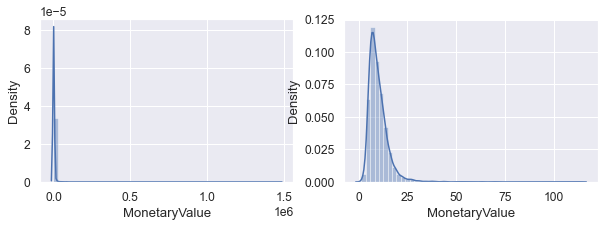

53.9
4.25


In [97]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.distplot(rfm['MonetaryValue'], ax=ax[0])
sns.distplot(np.cbrt(rfm['MonetaryValue']), ax=ax[1])
plt.show()
print(rfm['MonetaryValue'].skew().round(2))
print(np.cbrt(rfm['MonetaryValue']).skew().round(2))

In [98]:
pd.Series(np.cbrt(rfm['MonetaryValue'])).values

array([  7.19750428,  10.97880215,   6.05650326, ...,  10.90392923,
        13.28693386, 113.79405003])

By using the transformation, we will have data that less skewed. The skewness value declines from 16.63 to 1.16. Therefore, we can transform the RFM table with this code,

In [99]:
# Set the Numbers
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(rfm['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(rfm['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(rfm['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
4308,6.419299,3.657323,7.728829
4309,10.213088,2.662843,7.530248
4310,7.612872,4.731003,10.903929
4311,3.844546,5.032893,13.286934
4312,0.000000,16.140682,113.794050


Each variable don’t have the same mean and variance. We have to normalize it. To normalize, we can use StandardScaler object from scikit-learn library to do it. The code will look like this,

In [100]:
# Import library
from sklearn.preprocessing import StandardScaler
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) 
print(customers_normalized.std(axis = 0).round(2)) 

[-0. -0. -0.]
[1. 1. 1.]


In [101]:
pd.DataFrame(customers_normalized).head()

,0,1,2
0,0.980685,-0.197562,-0.537616
1,-1.711309,0.381805,0.193573
2,0.268054,-0.563249,-0.758251
3,-0.156647,0.664389,0.753606
4,-1.049610,-0.528062,-0.633578


Finally, we can do clustering using that data.

## Step 3 Model - Clustering with K-means algorithm

To make segmentation from the data, we can use the K-Means algorithm to do this.

K-Means algorithm is an unsupervised learning algorithm that uses the geometrical principle to determine which cluster belongs to the data. By determine each centroid, we calculate the distance to each centroid. Each data belongs to a centroid if it has the smallest distance from the other. It repeats until the next total of the distance doesn’t have significant changes than before.

### Determine the Optimal K

To make our clustering reach its maximum performance, we have to determine which hyperparameter fits to the data. To determine which hyperparameter is the best for our model and data, we can use the elbow method to decide. 

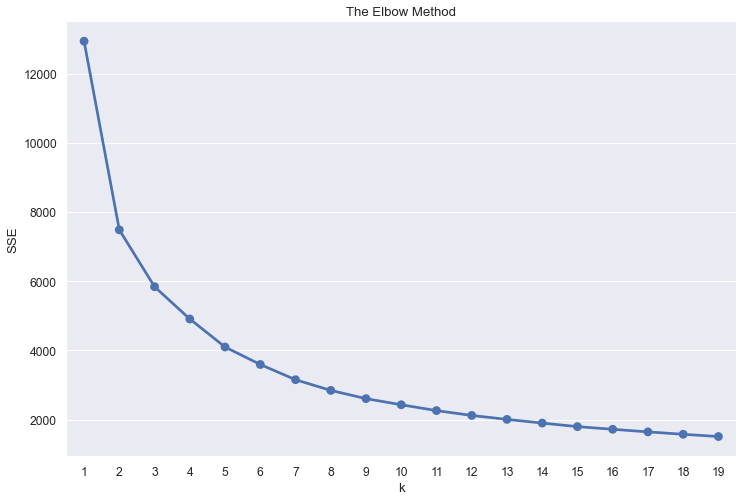

In [102]:
plt.figure(figsize=(12,8))

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
K = range(1, 20)

distortions = []
inertias = []
mapping1 = {}
sse = {}
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    
    distortions.append(sum(np.min(cdist(customers_normalized, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / customers_normalized.shape[0])
    inertias.append(kmeans.inertia_)
 
    mapping1[k] = sum(np.min(cdist(customers_normalized, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / customers_normalized.shape[0]
    
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [103]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 1.4793257397612396
2 : 1.1177983861560679
3 : 0.9826889773094838
4 : 0.896801526660862
5 : 0.8360599124735844
6 : 0.7820484802781082
7 : 0.7383909383656021
8 : 0.7147350271462767
9 : 0.6809021038729086
10 : 0.6561347310375708
11 : 0.6287791698033492
12 : 0.6087250714001586
13 : 0.6018886551030603
14 : 0.5933376574304885
15 : 0.5739368471070853
16 : 0.5642703596662972
17 : 0.5488398189242257
18 : 0.5375117812811734
19 : 0.5253474116868461


The x-axis is the value of the k, and the y-axis is the SSE value of the data. We will take the best parameter by looking at where the k-value will have a linear trend on the next consecutive k.
From the above plot, the k-value of 3 or 4 is the best hyperparameter for our model because the next k-value tend to have a linear trend. 

Let us now compare the clustering performance. For this purpose, I calculated the mean values of recency, frequency, and monetary metrics to get the following result:

### Fit the model

#### Fit the model - 3 cluster

In [104]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(4313,)

In [105]:
rfm.shape

(4313, 4)

By fitting the model, we can have clusters where each data belongs. By that, we can analyze the data.

In [106]:
rfm["Cluster"] = model.labels_
rfm.head()

,Customer ID,Recency,Frequency,MonetaryValue,Cluster
0,12346.0,165,33,372.86,1
1,12347.0,3,71,1323.32,2
2,12348.0,74,20,222.16,1
3,12349.0,43,102,2671.14,2
4,12351.0,11,21,300.93,2


In [107]:
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          21.8     449.6        9983.6   748
1         181.9      20.4         433.9  1606
2          43.2      69.2        1075.6  1959

#### Fit the model - 4 cluster

In [108]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

rfm["Cluster"] = model.labels_
rfm.head()
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          41.1     129.4        1909.7  1476
1          39.0      25.7         512.2  1184
2         212.4      24.4         487.5  1323
3          15.8     760.4       18793.1   330

From the above table, we can compare the distribution of mean values of recency, frequency, and monetary metrics across 3 and 4 cluster data. It seems that we get a more detailed distribution of our customer base using k=4. However, this may not be a very visually appealing method to extract insights.

Another commonly used method to compare the cluster segments is Snakeplots. They are commonly used in marketing research to understand customer perceptions.

Let us build a snake plot for our data with 4 clusters below.

### Cluster Exploration and Visualization

#### Snake Plots

Besides that, we can analyze the segments using snake plot. It requires the normalized dataset and also the cluster labels. By using this plot, we can have a good visualization from the data on how the cluster differs from each other.

In [109]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = rfm.index
df_normalized['Cluster'] = model.labels_
df_normalized.head()

,Recency,Frequency,MonetaryValue,ID,Cluster
0,0.980685,-0.197562,-0.537616,0,2
1,-1.711309,0.381805,0.193573,1,0
2,0.268054,-0.563249,-0.758251,2,1
3,-0.156647,0.664389,0.753606,3,0
4,-1.049610,-0.528062,-0.633578,4,1


In [110]:
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,0,2,Recency,0.980685
1,1,0,Recency,-1.711309
2,2,1,Recency,0.268054
3,3,0,Recency,-0.156647
4,4,1,Recency,-1.049610


In [111]:
df_nor_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12939 entries, 0 to 12938
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         12939 non-null  int64  
 1   Cluster    12939 non-null  int32  
 2   Attribute  12939 non-null  object 
 3   Value      12939 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 353.9+ KB


In [112]:
# Aggregate data by each customer
fig3 = df_nor_melt.groupby('Cluster').agg({'ID': lambda x: len(x)}).reset_index()


# Rename columns
fig3.rename(columns={'ID': 'Count'}, inplace=True)
fig3['percent'] = (fig3['Count'] / fig3['Count'].sum()) * 100
fig3['percent'] = fig3['percent'].round(1)

fig3.head()

,Cluster,Count,percent
0,0,4428,34.2
1,1,3552,27.5
2,2,3969,30.7
3,3,990,7.7


In [113]:
#Creating a Treemap with Plotly Express
# colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c'] #color palette
colors=['#bad0af','#d5e0cf','#f1f1f1','#f1d4d4'] #color palette
import plotly.express as px

fig = px.treemap(fig3, path=['Cluster'],values='Count'
                 , width=800, height=400
                 ,title="Distribution of Cluster")

fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

<AxesSubplot:xlabel='Attribute', ylabel='Value'>

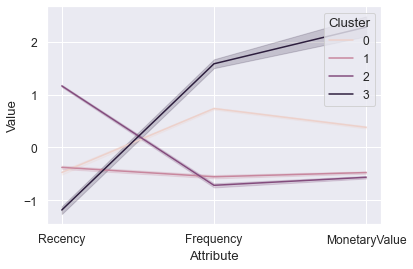

In [114]:
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

From the above snake plot, we can see the distribution of recency, frequency, and monetary metric values across the four clusters. The four clusters seem to be separate from each other, which indicates a good heterogeneous mix of clusters.

<br>

| Cluster | Type of customers| % | RFM Interpretation |
|:--|:--|:--|:--|
| 0 | New customers | 34% | Customers who transacted recently and have a lower purchase frequency, with a low amount of monetary spending.  | 
| 1 | At risk customers | 31% |  Customer who made their last transaction a while ago and who made frequent and large purchases in the past. |
| 2 | Lost customers/churned customers | 27% |  Customers who made their last transaction a long time ago, and who have made few purchases. Therefore, it could be the cluster of Lost customer/churned customers.  |
| 3 | Loyal customers | 8%  | Most frequent customers with the highest monetary spending amount and transact most recently  |

<br>

#### Comparing the different of rfm between population and clusters

In [115]:
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          41.1     129.4        1909.7  1476
1          39.0      25.7         512.2  1184
2         212.4      24.4         487.5  1323
3          15.8     760.4       18793.1   330

In [116]:
cluster_avg = rfm.groupby('Cluster').mean()
population_avg = rfm.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp

,Cluster,Frequency,MonetaryValue,Recency
Cluster,,,,
0,NaN,0.106089,-0.198152,-0.548780
1,NaN,-0.780186,-0.784935,-0.572086
2,NaN,-0.791564,-0.795313,1.330347
3,NaN,5.498156,6.891015,-0.826363


#### Scatter Plot

The scatter plot is the data analysis method we use when we have more than two variables. Remove the outlier from the plot to create a clear visualization result. Those outliers are taken into consideration in the model development. Exclude them only for visualization purposes. 

In [117]:
rfm_fig = rfm.copy()

#Remove the outlier for visualization
y1 = rfm_fig['Frequency']
size = rfm_fig.shape[0]
removed_outliers = y1.between(y1.quantile(.05), y1.quantile(.95))
print(str(y1[removed_outliers].size) + "/" + str(size) + " data points remain.") 
index_names = rfm_fig[~removed_outliers].index 
rfm_fig.drop(index_names, inplace=True)

#Remove the outlier for visualization
y2 = rfm_fig['Recency']
size = rfm_fig.shape[0]
removed_outliers = y2.between(y2.quantile(.05), y2.quantile(.95))
print(str(y2[removed_outliers].size) + "/" + str(size) + " data points remain.") 
index_names = rfm_fig[~removed_outliers].index 
rfm_fig.drop(index_names, inplace=True)

#Remove the outlier for visualization
y3 = rfm_fig['MonetaryValue']
size = rfm_fig.shape[0]
removed_outliers = y3.between(y3.quantile(.05), y3.quantile(.95))
print(str(y3[removed_outliers].size) + "/" + str(size) + " data points remain.") 
index_names = rfm_fig[~removed_outliers].index 
rfm_fig.drop(index_names, inplace=True)

3911/4313 data points remain.
3572/3911 data points remain.
3214/3572 data points remain.


#### Recency Vs frequency

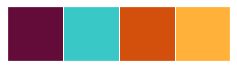

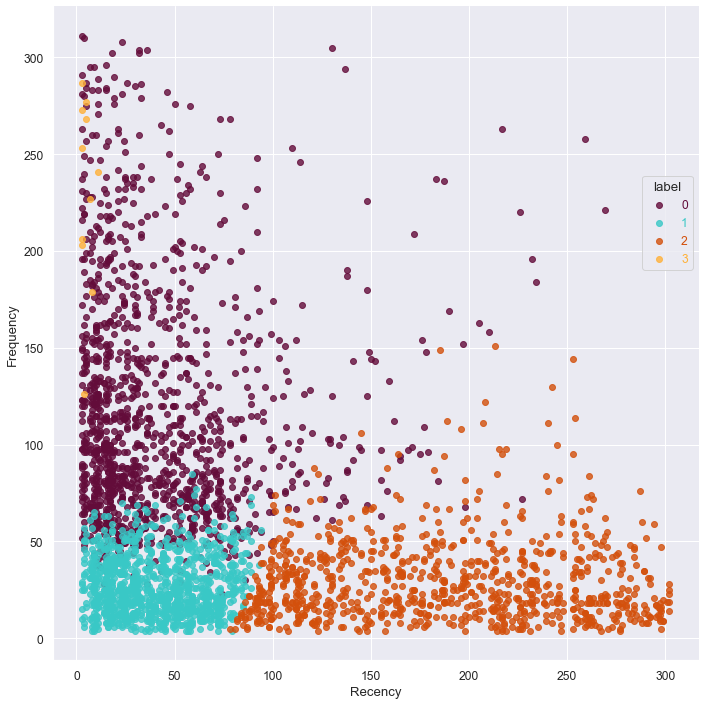

In [118]:
#define a custom palette
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
sns.set_palette(customPalette)
sns.palplot(customPalette)

data = pd.DataFrame(data=rfm_fig,columns=['Customer ID','Cluster','Recency','Frequency','MonetaryValue'])

#plot data with seaborn (don't add a legend yet)
facet = sns.lmplot(data=data, x='Recency', y='Frequency', hue='Cluster', height=10,
                   fit_reg=False, legend=False)

#add a legend
leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)
#change colors of labels
for i, text in enumerate(leg.get_texts()):
    plt.setp(text, color = customPalette[i])

A high frequency is found with customers who have a recent purchase within a month.

#### Frequency Vs Monetary

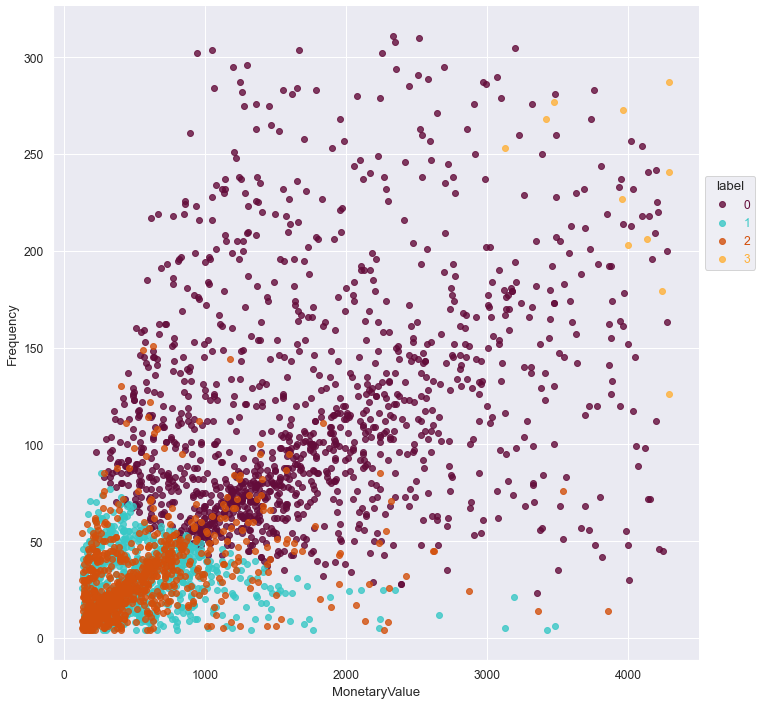

In [119]:

# fig, ax = plt.subplots(figsize=(10, 8))
#plot data with seaborn (don't add a legend yet)
facet = sns.lmplot(data=data, x='MonetaryValue', y='Frequency', hue='Cluster', height=10,
                   fit_reg=False, legend=False)

#add a legend
leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)
#change colors of labels
for i, text in enumerate(leg.get_texts()):
    plt.setp(text, color = customPalette[i])

Customers who buy frequently spend less money. 

#### Recency Vs Frequency Vs Monetary

In [120]:
rfm_fig['Cluster'] = rfm_fig['Cluster'].astype(str)

import plotly.express as px
fig = px.scatter_3d(rfm_fig,x='Recency', y='Frequency', z='MonetaryValue',
              color='Cluster', opacity=0.7,color_discrete_sequence=px.colors.qualitative.G10)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In the above plot, the color specifies Cluster. From the above plot, we can see how the customers are spread among Recency, Frequency and Monetary dimension. Customers in Cluster 1 have made recent purchases with a high frequency, but with lower amounts. The reason for this could be that the customer frequently purchase Accessories that are not so expensive.

We can also use the following method to understand the relative importance of segments in the data. To do this, we will complete the following steps:

1. Calculate average values of each cluster
2. Calculate average values of population
3. Calculate importance score by dividing them and subtracting 1 (ensures 0 is returned when cluster average equals population average)

In [121]:
cluster_avg = rfm[['Cluster','Recency','Frequency','MonetaryValue']].groupby(['Cluster']).mean()
population_avg = rfm[['Recency','Frequency','MonetaryValue']].head().mean()

In [122]:
cluster_avg

,Recency,Frequency,MonetaryValue
Cluster,,,
0,41.129404,129.440379,1909.666568
1,39.005068,25.723818,512.194299
2,212.414966,24.392290,487.478552
3,15.827273,760.448485,18793.098894


In [123]:
population_avg

Recency           59.200
Frequency         49.400
MonetaryValue    978.082
dtype: float64

As the final step in this analysis, we can extract this information now for each customer that can be used to map the customer with their relative importance by the company:

In [124]:
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,-0.31,1.62,0.95
1,-0.34,-0.48,-0.48
2,2.59,-0.51,-0.50
3,-0.73,14.39,18.21


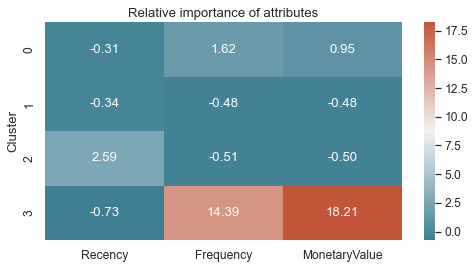

In [125]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)
# Plot heatmap
plt.figure(figsize=(8, 4))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap=cmap)
plt.show()

### Interpret the result

From the above analysis, we can see that there should be 4 clusters in our data. To understand what these 4 clusters mean in a business scenario, we should look back the table comparing the clustering performance of 3 and 4 clusters for the mean values of recency, frequency, and monetary metric. 

Below is the table giving the RFM interpretation of each segment and the points that a company is recommended to keep in mind while designing the marketing strategy for that segment of customers.


<br>

| Cluster | Type of customers| % | RFM Interpretation |
|:--|:--|:--|:--|
| 0 | New customers | 34% | Customers who transacted recently and have a lower purchase frequency, with a low amount of monetary spending.  | 
| 1 | At risk customers | 31% |  Customer who made their last transaction a while ago and who made frequent and large purchases in the past. |
| 2 | Lost customers/churned customers | 27% |  Customers who made their last transaction a long time ago, and who have made few purchases. Therefore, it could be the cluster of Lost customer/churned customers.  |
| 3 | Loyal customers | 8%  | Most frequent customers with the highest monetary spending amount and transact most recently  |

<br>

#### Using the RFM segmentation to identify the type of customer according to RFM score

#### Getting the individual RFM scores
Getting the individual RFM score can be done in several ways. You could use your own business expertise and heuristics to make rankings that suit your customer base. For this case, we are going to go the statistical route and rank our customer using quartiles.

The ranking of the individual RFM scores is done by dividing each of the RFM values into quartiles which creates four more or less equal buckets. We then rank each bucket from one to four; four being the best. Our summary table should now look something like this:

#### Define quartiles for RFM score:

In [126]:
# Create the quartiles scores
quantiles = rfm.quantile(q=[0.2,0.4,0.6,0.8])
quantiles = quantiles.to_dict()
    
def RScore(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 2
    else:
        return 1   
    
def FMScore(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 4
    else:
        return 5
    
rfm['R'] = rfm['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm['F'] = rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm['M'] = rfm['MonetaryValue'].apply(FMScore, args=('MonetaryValue',quantiles,))

#### Calculate the overall RFM score
This step can be done in two ways:

- Concatenation: creates segments Here we just concatenate (not add) the individual RFM score like strings and get labeled segments in return. Our best segment will be 444 and our worst will be 111 — signifying the lowest score on all three of the RFM categories.

- Addition: creates a score Here we add the individual RFM scores like numbers and get a number in return indicating the customer score. The score will range from 3 to 12 and we can use this to create more human friendly labelled categories.

In [127]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
rfm['RFM_Segment'] = rfm.apply(join_rfm, axis=1)
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

In [128]:
rfm['RFM_Segment'].unique()

array(['232', '544', '221', '345', '522', '322', '122', '445', '455',
       '535', '222', '111', '113', '123', '344', '133', '335', '413',
       '444', '144', '333', '255', '512', '311', '234', '334', '433',
       '143', '434', '213', '355', '212', '555', '423', '233', '545',
       '422', '511', '313', '425', '323', '245', '121', '155', '254',
       '112', '533', '435', '114', '312', '211', '134', '525', '443',
       '454', '244', '214', '424', '135', '411', '513', '215', '223',
       '242', '224', '412', '523', '324', '415', '154', '543', '431',
       '353', '132', '432', '414', '343', '115', '354', '531', '534',
       '532', '321', '124', '131', '331', '243', '235', '142', '554',
       '253', '421', '341', '145', '241', '542', '342', '231', '442',
       '325', '441', '332', '225', '524', '125', '514', '315', '553',
       '314', '453', '153', '352', '521', '452', '515', '152', '541'],
      dtype=object)

After calculations on the RFM data we can create customer segments that are actionable and easy to understand — like the ones below:

- Champions: Bought recently, buy often and spend the most
- Loyal customers: Buy on a regular basis. Responsive to promotions.
- Potential loyalist: Recent customers with average frequency.
- Recent customers: Bought most recently, but not often.
- Promising: Recent shoppers, but haven’t spent much.
- Needs attention: Above average recency, frequency and monetary values. May not have bought very recently though.
- About to sleep: Below average recency and frequency. Will lose them if not reactivated.
- At risk: Some time since they’ve purchased. Need to bring them back!
- Can’t lose them: Used to purchase frequently but haven’t returned for a long time.
- Hibernating: Last purchase was long back and low number of orders. May be lost.

#### Grouping and labelling with RFM label
For the RFM segment we are going to use the most common naming scheme, as outlined above. 

In [129]:
# Create human friendly RFM labels
segt_map = {
    
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At risk',
    r'[1-2]5': 'Can\'t lose them',
    r'3[1-2]': 'About to sleep',
    r'33': 'Need attention',
    r'[3-4][4-5]': 'Loyal customers',
    r'41': 'Promising',
    r'51': 'New customers',
    r'[4-5][2-3]': 'Potential loyalists',
    r'5[4-5]': 'Champions'
}
# rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)+ rfm['M'].map(str)
rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
# Create some human friendly labels for the scores
rfm['Score'] = 'Green'
rfm.loc[rfm['RFM_Score']>5,'Score'] = 'Bronze' 
rfm.loc[rfm['RFM_Score']>7,'Score'] = 'Silver' 
rfm.loc[rfm['RFM_Score']>9,'Score'] = 'Gold' 
rfm.loc[rfm['RFM_Score']>10,'Score'] = 'Platinum'
# List the head of the table to view the 
rfm.head(5)

,Customer ID,Recency,Frequency,MonetaryValue,Cluster,R,F,M,RFM_Segment,RFM_Score,Segment,Score
0,12346.0,165,33,372.86,2,2,3,2,232,7,At risk,Bronze
1,12347.0,3,71,1323.32,0,5,4,4,544,13,Champions,Platinum
2,12348.0,74,20,222.16,1,2,2,1,221,5,Hibernating,Green
3,12349.0,43,102,2671.14,0,3,4,5,345,12,Loyal customers,Platinum
4,12351.0,11,21,300.93,1,5,2,2,522,9,Potential loyalists,Silver


In [130]:
import seaborn as sns
sns.set_theme(style="whitegrid")

In [131]:
rfm.head()

,Customer ID,Recency,Frequency,MonetaryValue,Cluster,R,F,M,RFM_Segment,RFM_Score,Segment,Score
0,12346.0,165,33,372.86,2,2,3,2,232,7,At risk,Bronze
1,12347.0,3,71,1323.32,0,5,4,4,544,13,Champions,Platinum
2,12348.0,74,20,222.16,1,2,2,1,221,5,Hibernating,Green
3,12349.0,43,102,2671.14,0,3,4,5,345,12,Loyal customers,Platinum
4,12351.0,11,21,300.93,1,5,2,2,522,9,Potential loyalists,Silver


In [132]:
fig1 = rfm.groupby(['Segment']).count().unstack().fillna(0)
fig2 = rfm.groupby(['Score']).count().unstack().fillna(0)

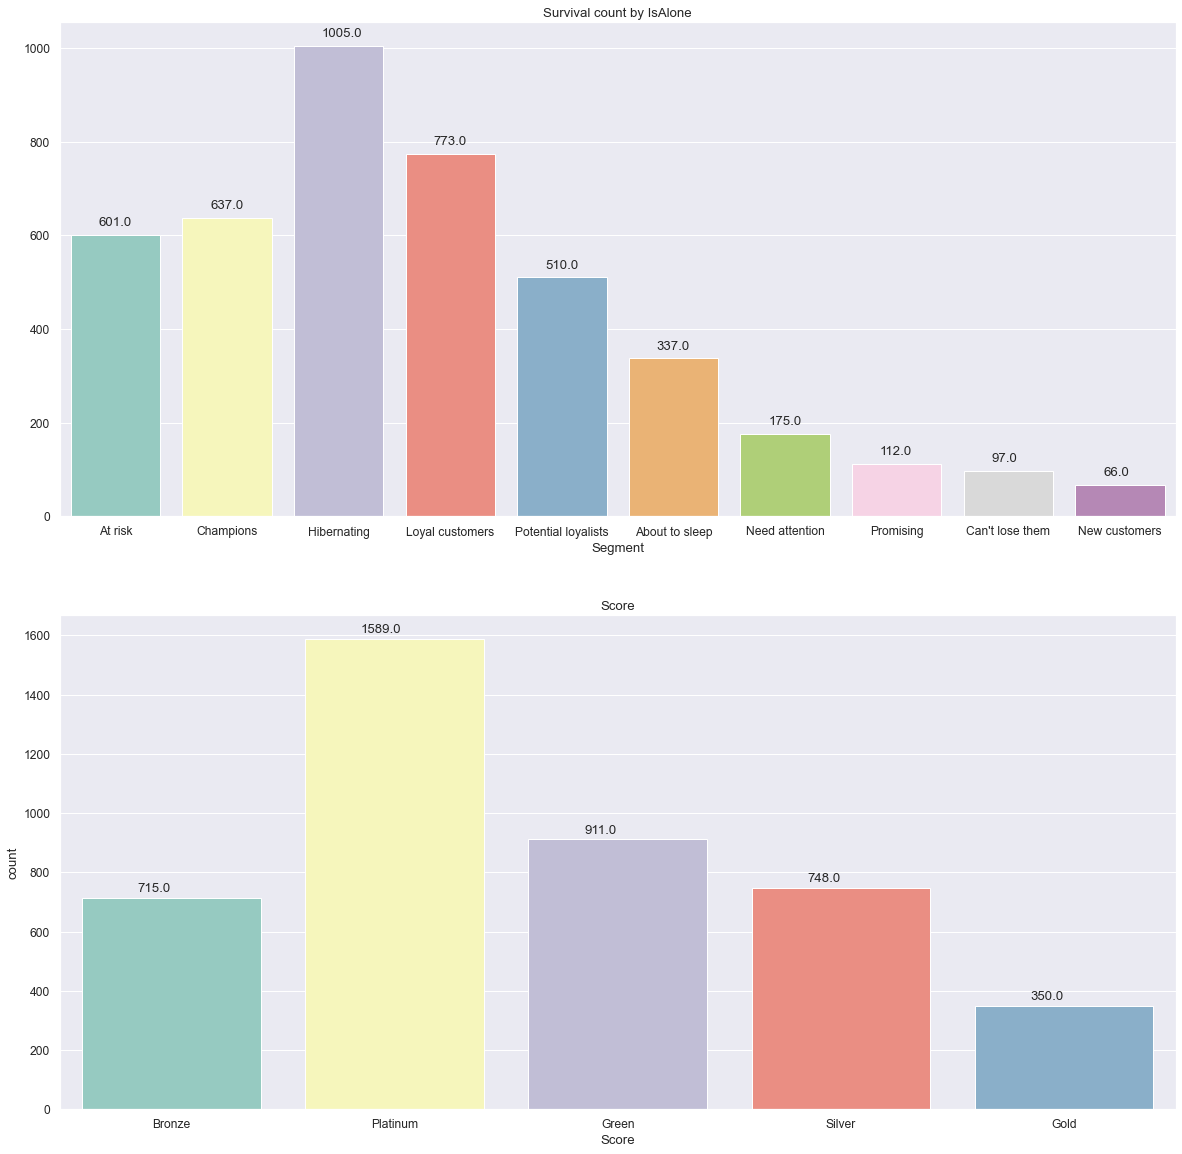

In [133]:
import matplotlib.pyplot as plt


sns.set(font_scale=1.1)

#Pie Chart
f,ax=plt.subplots(2,1,figsize=(20,20))
sns.countplot('Segment',data=rfm,ax=ax[0],palette="Set3")
ax[0].set_title('Segment')
ax[0].set_ylabel('')
ax[0].set_title('Survival count by IsAlone')
# ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

#Bar chart - count
sns.countplot('Score',data=rfm,ax=ax[1],palette="Set3")
ax[1].set_title('Score')

for p in ax[0].patches:
    ax[0].annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+20))

for p in ax[1].patches:
    ax[1].annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+20))


plt.show()

In [134]:
# Aggregate data by each customer
fig3 = rfm.groupby('Segment').agg({'Customer ID': lambda x: len(x)}).reset_index()

# Rename columns
fig3.rename(columns={'Customer ID': 'Count'}, inplace=True)
fig3['percent'] = (fig3['Count'] / fig3['Count'].sum()) * 100
fig3['percent'] = fig3['percent'].round(1)

fig3.head()

,Segment,Count,percent
0,About to sleep,337,7.8
1,At risk,601,13.9
2,Can't lose them,97,2.2
3,Champions,637,14.8
4,Hibernating,1005,23.3


In [135]:
#Creating a Treemap with Plotly Express
# colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c'] #color palette
colors=['#83af70','#9fbf8f','#bad0af','#d5e0cf','#f1f1f1','#f1d4d4','#f0b8b8','#ec9c9d'] #color palette
import plotly.express as px

fig = px.treemap(fig3, path=['Segment'],values='Count'
                 , width=800, height=400
                 ,title="RFM Segments")

fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

In [136]:
# Aggregate data by each customer
fig4 = rfm.groupby('Score').agg({'Customer ID': lambda x: len(x)}).reset_index()


# Rename columns
fig4.rename(columns={'Customer ID': 'Count'}, inplace=True)
fig4['percent'] = (fig4['Count'] / fig4['Count'].sum()) * 100
fig4['percent'] = fig4['percent'].round(1)

fig4.head()

,Score,Count,percent
0,Bronze,715,16.6
1,Gold,350,8.1
2,Green,911,21.1
3,Platinum,1589,36.8
4,Silver,748,17.3


In [137]:
#Creating a Treemap with Plotly Express
# colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c'] #color palette
colors=['#bad0af','#d5e0cf','#f1f1f1','#f1d4d4'] #color palette
import plotly.express as px

fig = px.treemap(fig4, path=['Score'],values='Count'
                 , width=800, height=400
                 ,title="Treemap of RFM Score")

fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

In [138]:
# Aggregate data by each customer
fig5 = rfm.groupby(['Cluster', 'Segment', 'Score']).agg({'Customer ID': lambda x: len(x)}).reset_index()

# Rename columns
fig5.rename(columns={'Customer ID': 'Count'}, inplace=True)
fig5['percent'] = (fig5['Count'] / fig5['Count'].sum()) * 100
fig5['percent'] = fig5['percent'].round(1)

fig5.head()
colors=['#bad0af','#d5e0cf','#f1f1f1','#f1d4d4'] #color palette
import plotly.express as px
fig = px.treemap(fig5, path=[px.Constant("Customer"), 'Cluster', 'Segment', 'Score'], values='Count'
                ,title="Treemap of Customer Segment")
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

#### Using RFM segment to Interpret the result

In [143]:
# Aggregate data by each customer
rfm1 = rfm.groupby(['Cluster','Segment'],).agg({'Customer ID': lambda x: len(x)}).reset_index()

# Rename columns
rfm1.rename(columns={'Customer ID': 'Count'}, inplace=True)
rfm1['percent'] = (rfm1['Count'] / rfm1.groupby('Cluster')['Count'].transform('sum')) * 100
rfm1['percent'] = rfm1['percent'].round(1)

rfm1

,Cluster,Segment,Count,percent
0,0,About to sleep,2,0.1
1,0,At risk,156,10.6
2,0,Can't lose them,88,6.0
3,0,Champions,411,27.8
4,0,Hibernating,4,0.3
5,0,Loyal customers,664,45.0
6,0,Need attention,45,3.0
7,0,Potential loyalists,106,7.2
8,1,About to sleep,330,27.9
9,1,At risk,55,4.6


### Step 4 Action to take for retain the customer

 Here's a handy chart of all the RFM Segments, and some actionable tips for each which can implement straight away!

What we have learned

<br>

| Cluster | Type of customers| % | RFM Label | RFM Interpretation | Actioinable insight | 
|:--|:--|:--|:--|:--|:--|
| 0 | New customers | 34% | 45% Loyal customers | Customers who transacted recently and have a lower purchase frequency, with a low amount of monetary spending. According to the RFM segmentation, half of them are loyal customers.   | To convert them into Champion customers, the Online Store should engage them more frequently|
| 1 | At risk customers | 31% | 28% About to Sleep; 33% Potential loyalists| Customer who made their last transaction a while ago and who made frequent and large purchases in the past. RFM segmentation shows that 30% of them are Potential Loyalists and 30% are About to Sleep. |The online store should offer the customer popular products at a discount or reconnect the customer |
| 2 | Lost customers/churned customers | 27% | 70% Hibernating | Customers who made their last transaction a long time ago, and who have made few purchases. Therefore, it could be the cluster of Lost customer/churned customers. Additionally, RFM segmentation shows that most customers are Hibernating in this cluster  | A marketing campaign should be launched to revive interest in online stores |
| 3 | Loyal customers | 8% | 67% Champions | Most frequent customers with the highest monetary spending amount and transact most recently  |The online store should upsell higher value products and solicit reviews from this group of customers to provide better service and products |

<br>

Based on RFM analysis, there are 8% of loyal customers who tend to spend big amount of money while buying. Also there are groups of customers who are already lost and who are going to be lost in near future.

### Further analysis
Addition of new variables like Tenure: The number of days since the first transaction by each customer. This will tell us how long each customer has been with the system.
Conducting deeper segmentation on customers based on their geographical location, and demographic and psychographic factors.

Thanks for reading!!! 😊 🍀

In [144]:
!jupyter nbconvert --to html RFManalysis_GitHub.ipynb

[NbConvertApp] Converting notebook RFManalysis_GitHub.ipynb to html
[NbConvertApp] Writing 1524691 bytes to RFManalysis_GitHub.html
